In [32]:
import torch.nn as nn
import torch.optim as optim

In [2]:
from lstm import LSTM
from preprocessing import *
from utils import *
from features import *

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.)
else:
    device = torch.device("cpu")
device

device(type='mps')

In [4]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [5]:
seq_len = 72
scale_output=True
target_column = 'NO1_consumption'

In [7]:
features_to_add = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO1_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        add_hour_columns,
        {}
    ),
    (
        previous_y,
        {'target': target_column}
    )
]


In [8]:
for feature in features_to_add:
    print(feature)

(<function pick_location_data at 0x2942d9630>, {'loc': [1]})
(<function add_season_columns at 0x2942d9480>, {})
(<function shift_data at 0x2942d96c0>, {'shift_max': 10, 'column_to_shift': 'NO1_temperature', 'new_column_name': 'temp'})
(<function add_hour_columns at 0x2942d9510>, {})
(<function previous_y at 0x2942d8dc0>, {'target': 'NO1_consumption'})


In [9]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), df_target = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add,
        seq_len=seq_len,
        scale_output=scale_output
    )

columns <class 'list'>
FEATURES:
 Index(['NO1_consumption_1_previous', 'NO1_temperature', 'season_fall',
       'season_spring', 'season_summer', 'season_winter', 'temp_1_previous',
       'temp_2_previous', 'temp_3_previous', 'temp_4_previous',
       'temp_5_previous', 'temp_6_previous', 'temp_7_previous',
       'temp_8_previous', 'temp_9_previous', 'temp_10_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [10]:
input_size = X_train.shape[2]
hidden_size = 11
num_layers = 3

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model.to(device)

LSTM(
  (lstm): LSTM(40, 11, num_layers=3, batch_first=True)
  (linear): Linear(in_features=11, out_features=1, bias=True)
)

In [29]:
lr = 1e-3
num_epochs=100

In [12]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [13]:
path2 = "LSTM-prev-y-2024-03-20-loss-0.04269014"
path2 = "models/" + path2
model.load_state_dict(torch.load(path2))
model.to(device)

LSTM(
  (lstm): LSTM(40, 11, num_layers=3, batch_first=True)
  (linear): Linear(in_features=11, out_features=1, bias=True)
)

In [30]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs
)

device: mps


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


In [27]:
# path = f'models/LSTM-prev-y-{str(datetime.now().date())}-loss-{str(losses[len(losses)-1])}'
# torch.save(model.state_dict(), path)

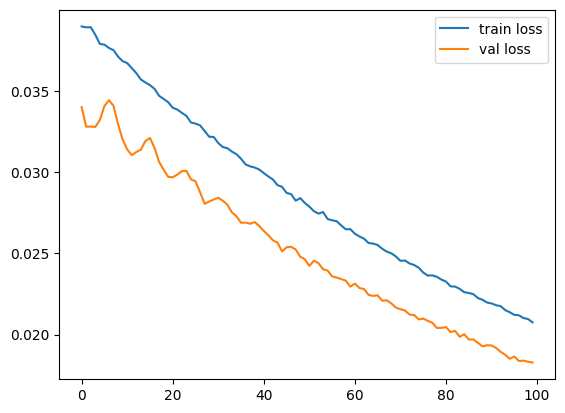

In [31]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [23]:
y_test, y_pred = predict(model, scalerOutputMethod, (X_test, y_test))

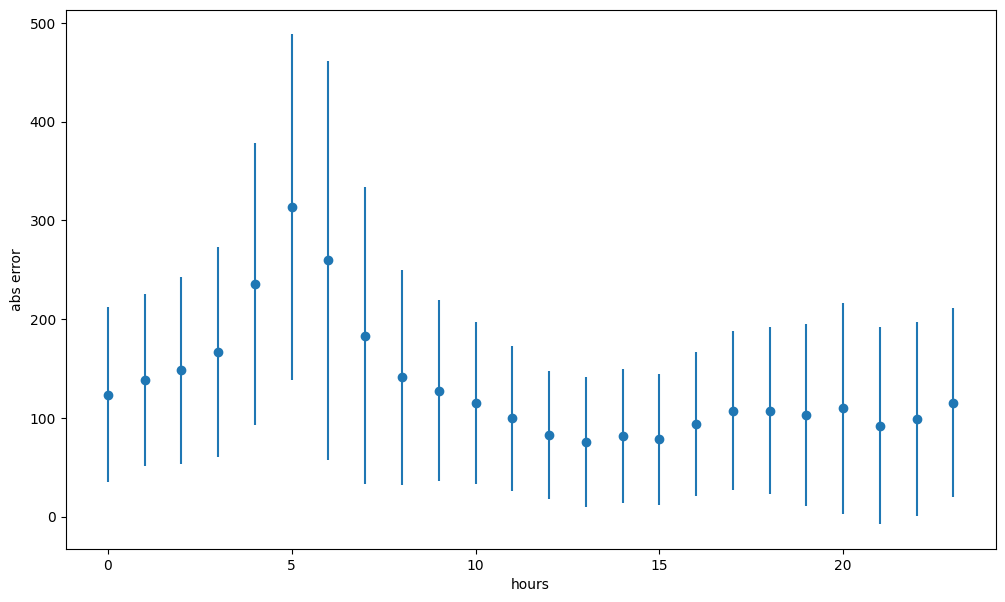

In [24]:
plot_error_by_hour_for_test_set(y_test, y_pred, start_hour=df_target['timestamp'].dt.hour.iloc[seq_len-1])

0
forecast_array 24 x_axis 24


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


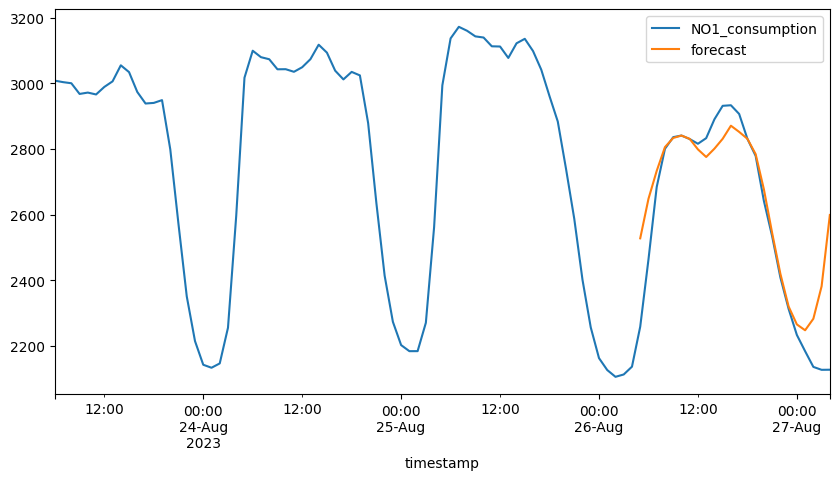

0
forecast_array 24 x_axis 24


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


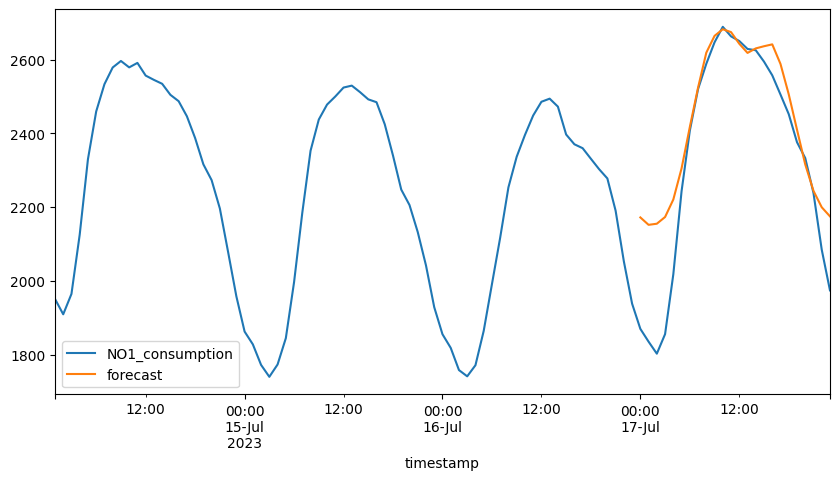

0
forecast_array 24 x_axis 24


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


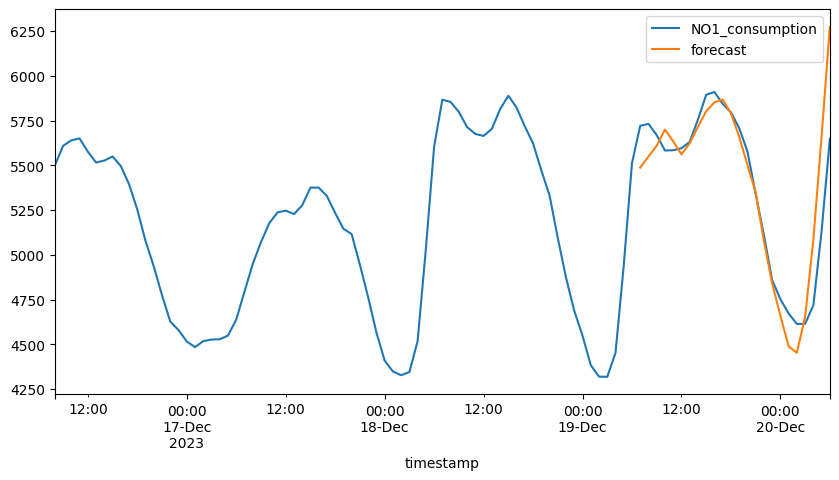

0
forecast_array 24 x_axis 24


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


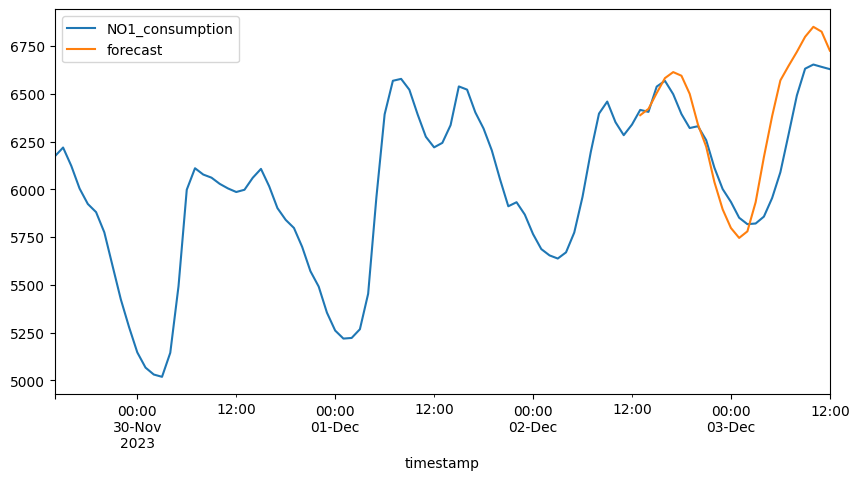

0
forecast_array 24 x_axis 24


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


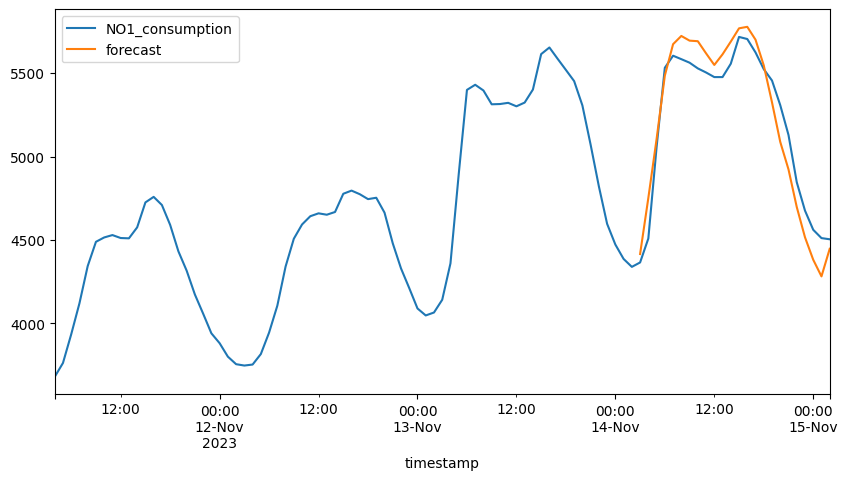

In [22]:
for k in range(5):
    make_forecast_replace_previous_y(model, scalerOutputMethod, (X_test, y_test), seq_len=seq_len)